# Walmart - Store Sales Forecasting : 분류 예측 알고리즘(2022-06-15)
* url : https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting

---
---

In [243]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patches as mpathces
import matplotlib.lines as mlines
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose

pd.options.display.float_format = '{:.3f}'.format # 과학적표기법 대신 소수점 3자리 까지 나타낸다.

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
pd.set_option('mode.chained_assignment',  None)

from matplotlib import font_manager,rc # 한글 글꼴 사용
rc('font', family='AppleGothic') 
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
# folder name : JG/practice_amazon_forecast

train = pd.read_csv('raw_data/train.csv')
test = pd.read_csv('raw_data/test.csv')
features = pd.read_csv('raw_data/features.csv')
stores = pd.read_csv('raw_data/stores.csv')
submission = pd.read_csv('raw_data/sampleSubmission.csv')

---
---

# **목차**
* 데이터 분석 목적
* 상점 분석
* 부서 분석(타입별 특성)
* 전체 상점과 개별 상점의 정합성
* 결론

---

# 1. 데이터 분석 목적

#### 부서를 분류하기 위한 분류 기준 판단 및 알고리즘 개발

In [4]:
print('-'*20 + " 매장 정보 " + '-'*20)
print("제품이 판매되는 매장 수 :",train['Store'].nunique())
print("제품이 판매되는 A 타입 매장 수 :",stores[stores['Type'] == 'A'].count().Store)
print("제품이 판매되는 B 타입 매장 수 :",stores[stores['Type'] == 'B'].count().Store)
print("제품이 판매되는 C 타입 매장 수 :",stores[stores['Type'] == 'C'].count().Store)
print("제품이 판매되는 매장 타입 :",stores['Type'].unique())
print("제품이 판매되는 매장 크기 :",stores['Size'].min(),"~", stores['Size'].max())
print('-'*20 + " 제품 정보 " + '-'*20)
print("전체 부서 수 :",train['Dept'].min(),"~",train['Dept'].max())
print("제품이 판매되는 부서 수 :",train['Dept'].nunique())

-------------------- 매장 정보 --------------------
제품이 판매되는 매장 수 : 45
제품이 판매되는 A 타입 매장 수 : 22
제품이 판매되는 B 타입 매장 수 : 17
제품이 판매되는 C 타입 매장 수 : 6
제품이 판매되는 매장 타입 : ['A' 'B' 'C']
제품이 판매되는 매장 크기 : 34875 ~ 219622
-------------------- 제품 정보 --------------------
전체 부서 수 : 1 ~ 99
제품이 판매되는 부서 수 : 81


#### 45개 매장의 81개 부서에 대해 각종 변수들을 활용하여 부서 분류  

## 1.1 Data Overview

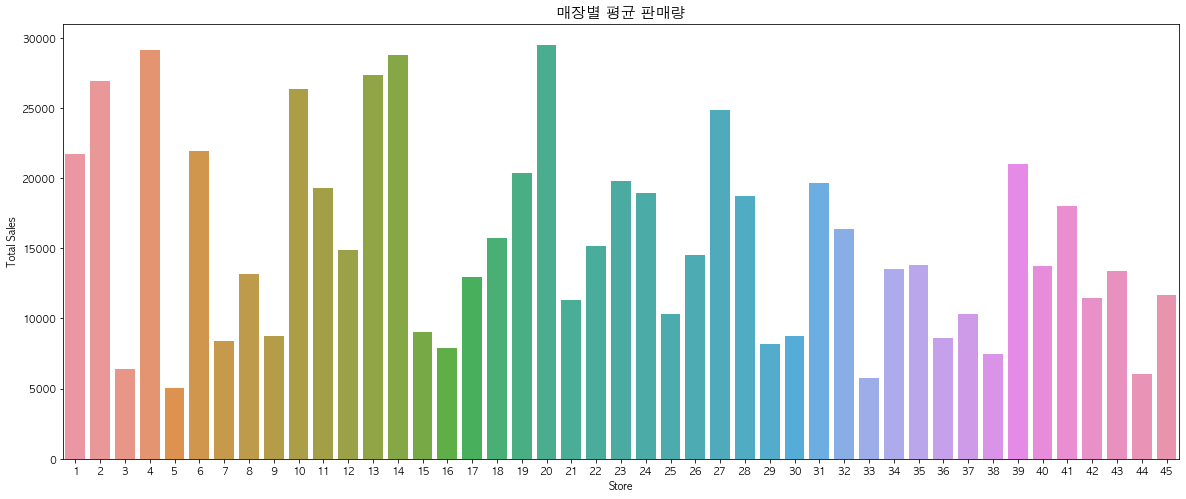

In [13]:
plt.figure(figsize=(20,8))
sns.barplot(train_features['Weekly_Sales'].groupby(train_features['Store']).sum().index,train_features['Weekly_Sales'].groupby(train_features['Store']).mean().values)
plt.ylabel("Total Sales")
plt.title("매장별 평균 판매량",fontsize=15)
plt.show()

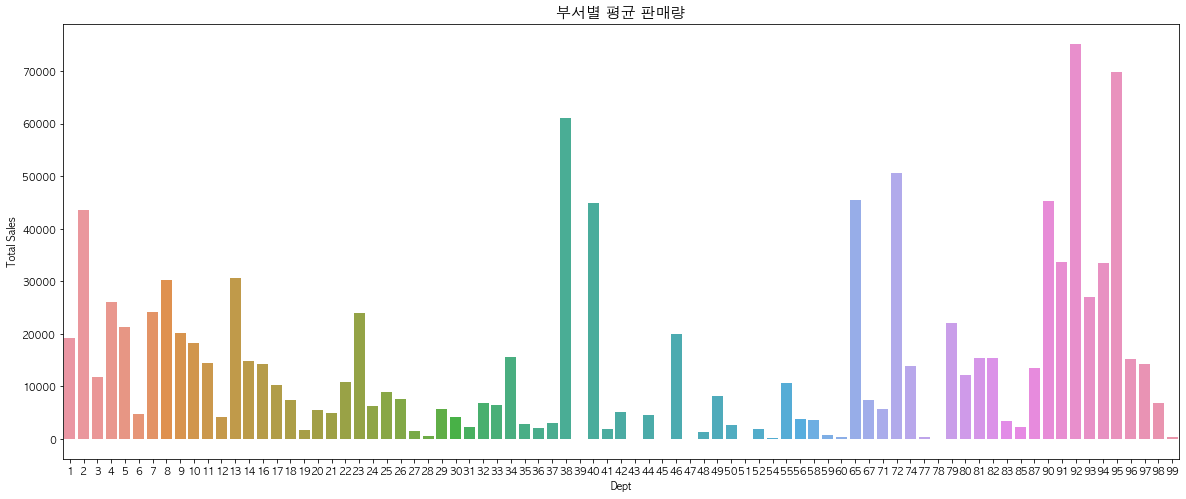

In [22]:
plt.figure(figsize=(20,8))
sns.barplot(train_features['Weekly_Sales'].groupby(train_features['Dept']).sum().index,train_features['Weekly_Sales'].groupby(train_features['Dept']).mean().values)
plt.ylabel("Total Sales")
plt.title("부서별 평균 판매량",fontsize=15)
plt.show()

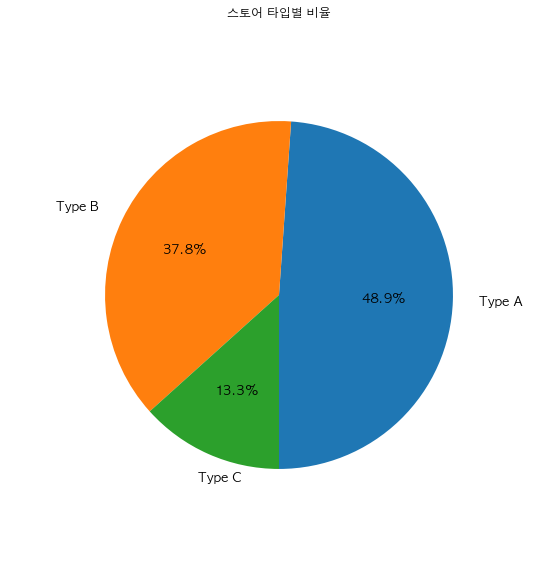

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.pie(stores['Type'].value_counts() / len(stores['Type']),
        labels=['Type A','Type B','Type C'],
        textprops={'fontsize':13},
        startangle=270,
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.15,
        radius=0.8,
        center=(0.5,0.5))
plt.title("스토어 타입별 비율")
plt.show()

## 1.2 Data Merge

In [7]:
features_store = features.merge(stores,how='left',on='Store')
train_features = train.merge(features_store, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)
train_features['Date'] = pd.to_datetime(train_features['Date'])

---
# 2. 상점 분석

## 2.1 기온에 따른 상점 특성

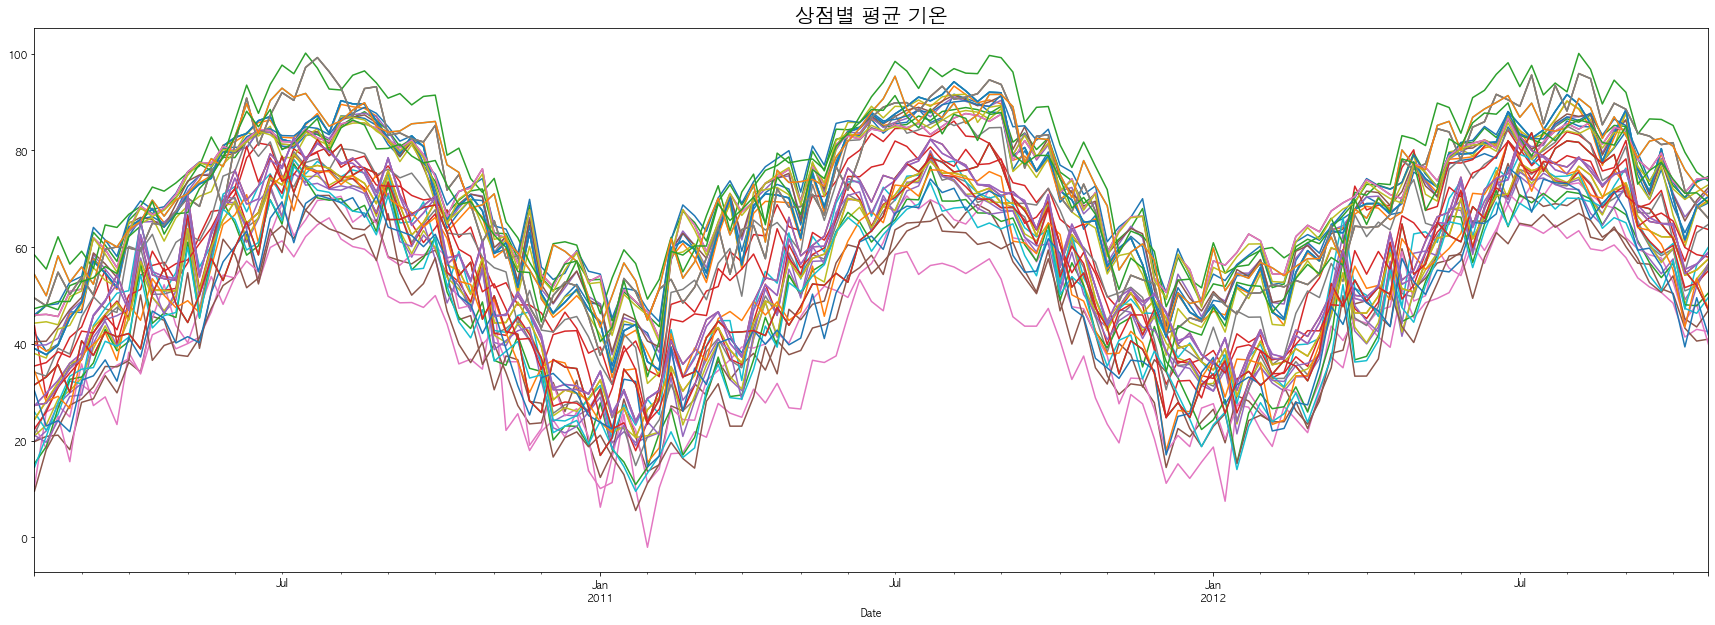

In [44]:
for i in train_features['Store'].unique():
    train_features[train_features['Store'] == i]['Temperature'].groupby(train_features['Date']).mean().plot(figsize=(30,10))
plt.title("상점별 평균 기온",fontsize=20)
plt.show()

#### 클러스터링을 위해 상점별 기온 DataFrame 생성

In [46]:
temp_df = pd.DataFrame()
temp_df2 = pd.DataFrame()
for i in train_features['Store'].unique():
    temp = pd.DataFrame(train_features[train_features['Store'] == i]['Temperature'].groupby(train_features['Date']).mean())
    temp_df = pd.concat([temp_df,temp],axis=1)
x = pd.concat([temp_df,temp_df2],axis=1)
x.columns = [i for i in train_features['Store'].unique()]
x

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,42.310,40.190,45.710,43.760,39.700,40.430,10.530,34.140,38.010,54.340,...,45.970,45.970,49.470,44.300,14.480,30.270,54.340,47.310,31.530,27.310
2010-02-12,38.510,38.490,47.930,28.840,39.810,40.570,25.900,33.340,37.080,49.960,...,46.110,46.110,47.870,44.580,20.840,23.040,49.960,47.990,33.160,27.730
2010-02-19,39.930,39.690,47.070,36.450,41.140,43.580,27.280,39.100,43.060,58.220,...,45.660,45.660,54.830,43.960,27.840,24.130,58.220,48.770,35.700,31.270
2010-02-26,46.630,46.100,52.050,41.360,46.700,47.100,24.910,37.910,43.830,52.770,...,50.870,50.870,50.230,49.790,33.320,21.840,52.770,48.770,29.980,34.890
2010-03-05,46.500,47.170,53.040,43.490,48.890,49.630,35.860,45.640,48.430,55.920,...,51.330,51.330,53.770,50.930,34.780,32.490,55.920,52.890,40.650,37.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,76.080,79.450,77.460,71.740,78.330,77.820,50.640,71.100,76.800,82.520,...,79.490,79.490,81.220,78.040,50.980,56.080,82.520,77.550,64.800,64.880
2012-10-05,68.550,70.270,72.740,63.070,71.170,70.840,48.430,61.410,66.610,80.880,...,73.570,73.570,81.610,72.050,57.210,50.140,80.880,74.090,61.790,64.890
2012-10-12,62.990,60.970,70.310,57.110,66.240,65.430,41.430,55.030,60.090,76.030,...,71.280,71.280,71.740,69.880,47.350,39.380,76.030,71.140,55.100,54.470


## 2.1.1 기온에 따른 상점 클러스터링(2개)

In [47]:
# 클러스터링 모델 생성
kmeans_2 = KMeans(n_clusters=2, random_state = 42, init='random').fit(x.T)
result_df2 = x.T.copy()

# 클러스터 ID 생성
result_df2.loc[:,'clusterID'] = kmeans_2.labels_
# 실루엣 계수값
score_samples = silhouette_samples(result_df2, result_df2['clusterID'])
# 실루엣 계수 컬럼 생성
result_df2.loc[:,'silhouette coefficient'] = score_samples

In [48]:
# 실루엣계수의 평균이 커야 좋다
# 실루엣계수의 편차가 작아야 좋다

print('전체 데이터의 실루엣 계수 평균')
print(result_df2['silhouette coefficient'].mean())
print('\n군집별 실루엣 계수 평균')
result_df2.groupby('clusterID')['silhouette coefficient'].mean().reset_index()

전체 데이터의 실루엣 계수 평균
0.62018026320309

군집별 실루엣 계수 평균


,clusterID,silhouette coefficient
0,0,0.677
1,1,0.566


## 2.1.2 기온에 따른 상점 클러스터링(3개)

In [49]:
# 클러스터링 모델 생성
kmeans_3 = KMeans(n_clusters=3, random_state = 42, init='random').fit(x.T)
result_df3 = x.T.copy()

# 클러스터 ID 생성
result_df3.loc[:,'clusterID'] = kmeans_3.labels_
# 실루엣 계수값
score_samples = silhouette_samples(result_df3, result_df3['clusterID'])
# 실루엣 계수 컬럼 생성
result_df3.loc[:,'silhouette coefficient'] = score_samples

In [50]:
print('전체 데이터의 실루엣 계수 평균')
print(result_df3['silhouette coefficient'].mean())
print('\n군집별 실루엣 계수 평균')
result_df3.groupby('clusterID')['silhouette coefficient'].mean().reset_index()

전체 데이터의 실루엣 계수 평균
0.5248889846921938

군집별 실루엣 계수 평균


,clusterID,silhouette coefficient
0,0,0.493
1,1,0.301
2,2,0.619


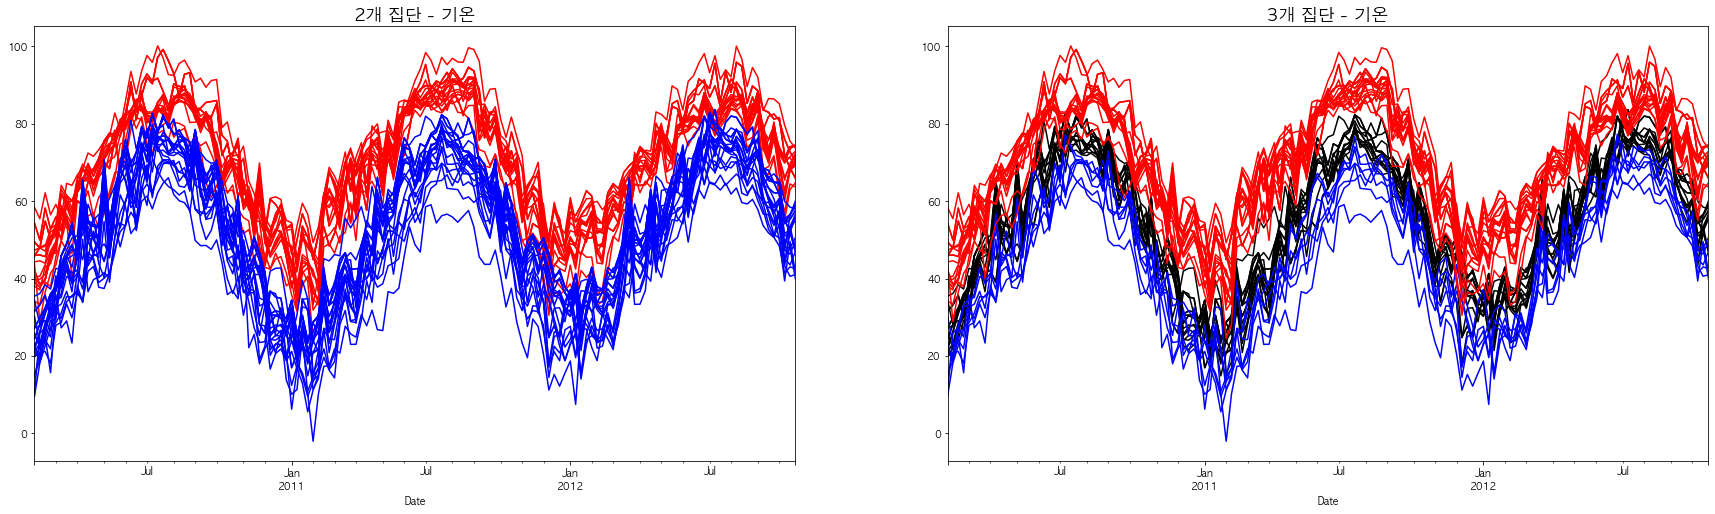

In [55]:
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax = ax.flatten()

# 클러스터링(2개) 한 집단의 기온
for i in result_df2[result_df2['clusterID']==0].T.columns:
    train_features[train_features['Store'] == i]['Temperature'].groupby(train_features['Date']).mean().plot(color='r',label='high',ax=ax[0])
for i in result_df2[result_df2['clusterID']==1].T.columns:
    train_features[train_features['Store'] == i]['Temperature'].groupby(train_features['Date']).mean().plot(color='b',label='low',ax=ax[0])
ax[0].set_title("2개 집단 - 기온",fontsize=17)


# 클러스터링(3개) 한 집단의 기온
for i in result_df3[result_df3['clusterID']==0].T.columns:
    train_features[train_features['Store'] == i]['Temperature'].groupby(train_features['Date']).mean().plot(color='black',label='middle',ax=ax[1])
for i in result_df3[result_df3['clusterID']==1].T.columns:
    train_features[train_features['Store'] == i]['Temperature'].groupby(train_features['Date']).mean().plot(color='b',label='low',ax=ax[1])
for i in result_df3[result_df3['clusterID']==2].T.columns:
    train_features[train_features['Store'] == i]['Temperature'].groupby(train_features['Date']).mean().plot(color='r',label='high',ax=ax[1])
ax[1].set_title("3개 집단 - 기온",fontsize=17)
plt.show()

## 2.1.3 클러스터링(2개)한 스토어의 판매량,기온 관계

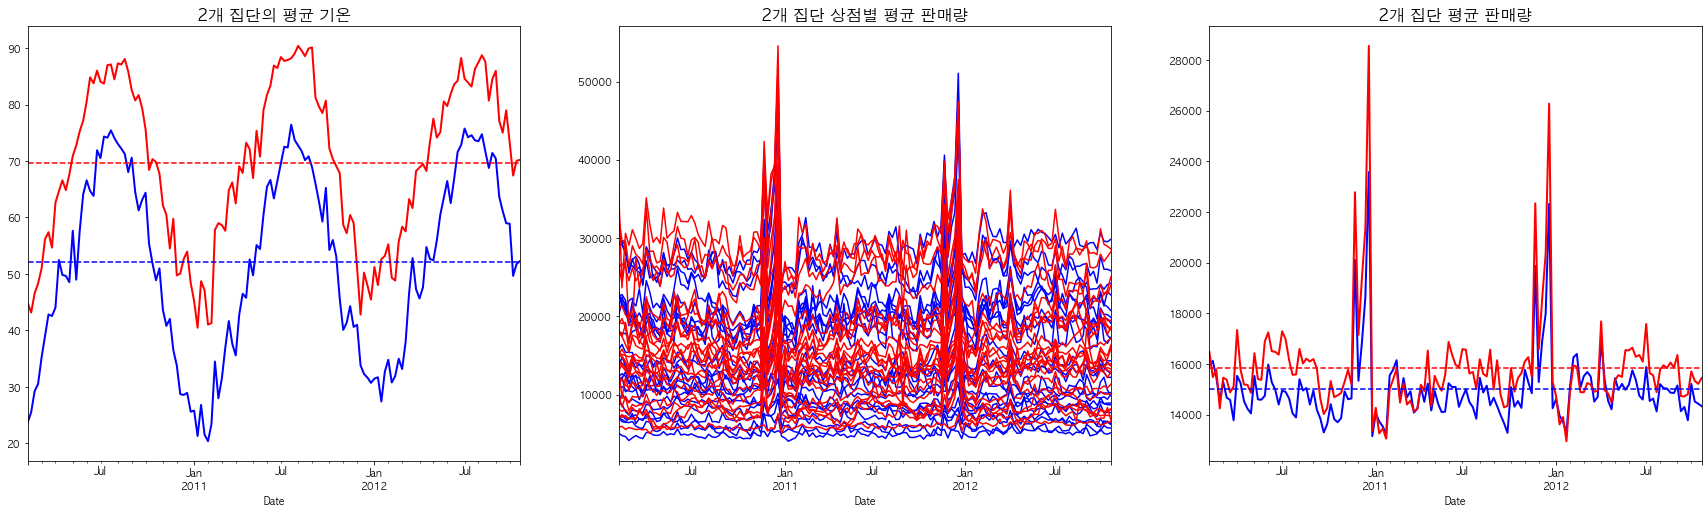

In [59]:
fig, ax = plt.subplots(1,3, figsize=(30,8))
ax = ax.flatten()

# 1
temp0 = pd.DataFrame()
for i in result_df2[result_df2['clusterID']==0].T.columns:
    temp0 = temp0.append(train_features[train_features['Store']==i]['Temperature'].groupby(train_features['Date']).mean())
temp0.T.mean(axis=1).plot(color='r',linewidth=2,ax=ax[0])

temp1 = pd.DataFrame()
for i in result_df2[result_df2['clusterID']==1].T.columns:
    temp1 = temp1.append(train_features[train_features['Store']==i]['Temperature'].groupby(train_features['Date']).mean())
temp1.T.mean(axis=1).plot(color='b',linewidth=2,ax=ax[0])

ax[0].axhline(y=temp0.T.mean().mean(),color='r',linestyle='--')
ax[0].axhline(y=temp1.T.mean().mean(),color='b',linestyle='--')
ax[0].set_title("2개 집단의 평균 기온",fontsize=16)

# 2
for i in result_df2[result_df2['clusterID']==0].T.columns:
    train_features[train_features['Store'] == i]['Weekly_Sales'].groupby(train_features['Date']).mean().plot(color='b',label='middle',ax=ax[1])
for i in result_df2[result_df2['clusterID']==1].T.columns:
    train_features[train_features['Store'] == i]['Weekly_Sales'].groupby(train_features['Date']).mean().plot(color='r',label='low',ax=ax[1])
ax[1].set_title("2개 집단 상점별 평균 판매량",fontsize=16)   

# 3
temp0 = pd.DataFrame()
for i in result_df2[result_df2['clusterID']==0].T.columns:
    temp0 = temp0.append(train_features[train_features['Store']==i]['Weekly_Sales'].groupby(train_features['Date']).mean())
temp0.T.mean(axis=1).plot(color='b',linewidth=2,ax=ax[2])

temp1 = pd.DataFrame()
for i in result_df2[result_df2['clusterID']==1].T.columns:
    temp1 = temp1.append(train_features[train_features['Store']==i]['Weekly_Sales'].groupby(train_features['Date']).mean())
temp1.T.mean(axis=1).plot(color='r',linewidth=2,ax=ax[2])
# ax[1].axhline(y=temp1.T.mean().mean(),color='b')

ax[2].axhline(y=temp0.T.mean().mean(),color='b',linestyle='--')
ax[2].axhline(y=temp1.T.mean().mean(),color='r',linestyle='--')
ax[2].set_title("2개 집단 평균 판매량",fontsize=16)
plt.show()

## 2.2 크기에 따른 상점 특성

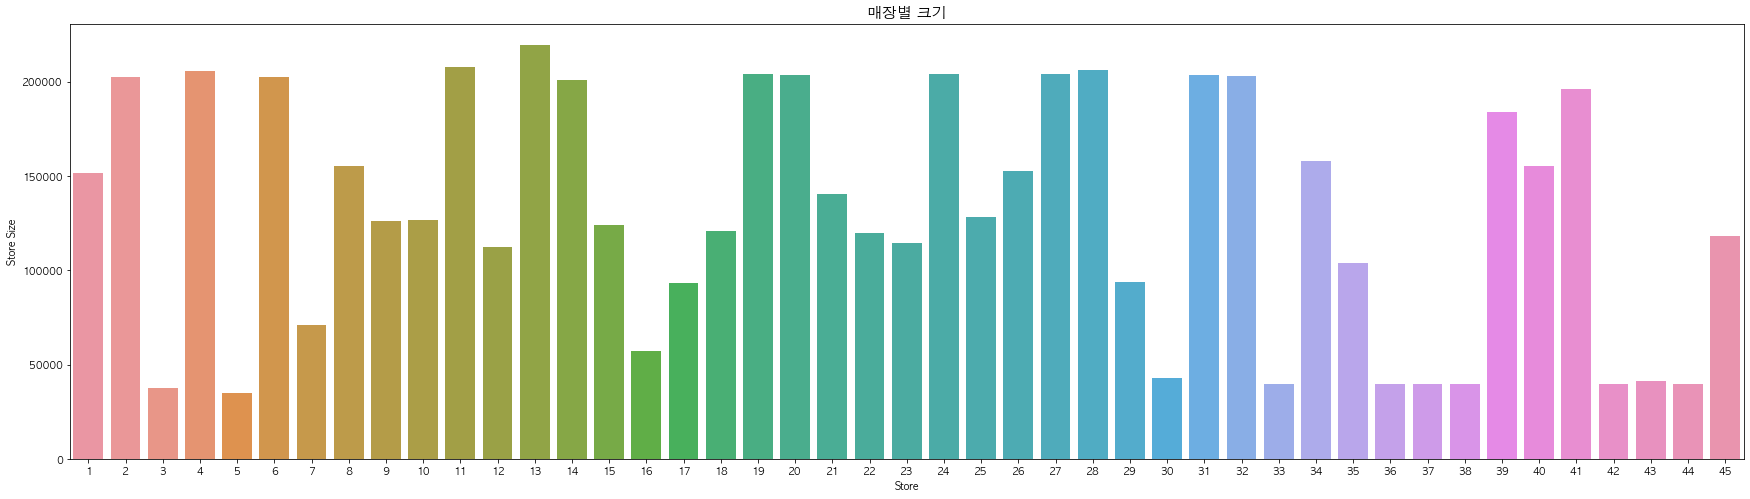

In [62]:
plt.figure(figsize=(30,8))
sns.barplot(train_features['Size'].groupby(train_features['Store']).sum().index,train_features['Size'].groupby(train_features['Store']).mean().values)
plt.ylabel("Store Size")
plt.title("매장별 크기",fontsize=15)
plt.show()

#### 클러스터링을 위해 상점,크기 DataFrame 생성

In [65]:
x = train_features[['Store','Size']].drop_duplicates().set_index('Store')

## 2.2.1 크기에 따른 상점 클러스터링(2개)

In [66]:
# 클러스터링 모델 생성
kmeans_2 = KMeans(n_clusters=2, random_state = 42, init='random').fit(x)
result_df2 = x.copy()

# 클러스터 ID 생성
result_df2.loc[:,'clusterID'] = kmeans_2.labels_
# 실루엣 계수값
score_samples = silhouette_samples(result_df2, result_df2['clusterID'])
# 실루엣 계수 컬럼 생성
result_df2.loc[:,'silhouette coefficient'] = score_samples

In [67]:
# 실루엣계수의 평균이 커야 좋다
# 실루엣계수의 편차가 작아야 좋다

print('전체 데이터의 실루엣 계수 평균')
print(result_df2['silhouette coefficient'].mean())
print('\n군집별 실루엣 계수 평균')
result_df2.groupby('clusterID')['silhouette coefficient'].mean().reset_index()

전체 데이터의 실루엣 계수 평균
0.6292065286577437

군집별 실루엣 계수 평균


,clusterID,silhouette coefficient
0,0,0.723
1,1,0.547


## 2.2.2 크기에 따른 상점 클러스터링(3개)

In [71]:
# 클러스터링 모델 생성
kmeans_3 = KMeans(n_clusters=3, random_state = 42, init='random').fit(x)
result_df3 = x.copy()

# 클러스터 ID 생성
result_df3.loc[:,'clusterID'] = kmeans_3.labels_
# 실루엣 계수값
score_samples = silhouette_samples(result_df3, result_df3['clusterID'])
# 실루엣 계수 컬럼 생성
result_df3.loc[:,'silhouette coefficient'] = score_samples

In [72]:
# 실루엣계수의 평균이 커야 좋다
# 실루엣계수의 편차가 작아야 좋다

print('전체 데이터의 실루엣 계수 평균')
print(result_df3['silhouette coefficient'].mean())
print('\n군집별 실루엣 계수 평균')
result_df3.groupby('clusterID')['silhouette coefficient'].mean().reset_index()

전체 데이터의 실루엣 계수 평균
0.7690083217056729

군집별 실루엣 계수 평균


,clusterID,silhouette coefficient
0,0,0.584
1,1,0.876
2,2,0.905


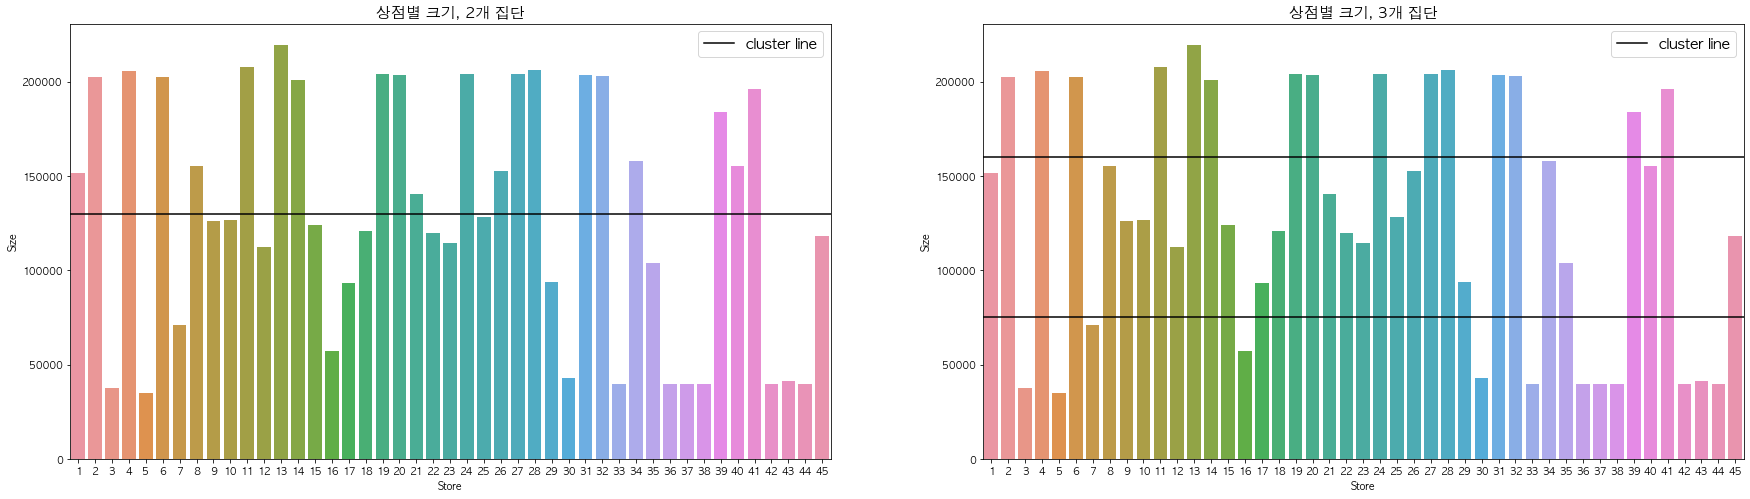

In [75]:
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax = ax.flatten()

# 클러스터링(2개) 한 집단의 크기
sns.barplot(result_df2.index,result_df2['Size'],ax=ax[0])
ax[0].set_ylabel("Size")
ax[0].axhline(y=130000,color='black')
ax[0].set_title("상점별 크기, 2개 집단",fontsize=15)
black_line = mlines.Line2D([], [], color='black',linestyle = '-', label='cluster line')
ax[0].legend(handles=[black_line],fontsize=15)


# 클러스터링(3개) 한 집단의 크기
sns.barplot(result_df3.index,result_df3['Size'],ax=ax[1])
ax[1].set_ylabel("Size")
ax[1].axhline(y=160000,color='black')
ax[1].axhline(y=75000,color='black')
ax[1].set_title("상점별 크기, 3개 집단",fontsize=15)
black_line = mlines.Line2D([], [], color='black',linestyle = '-', label='cluster line')
ax[1].legend(handles=[black_line],fontsize=15)
plt.show()

## 2.2.3 클러스터링(3개)한 스토어의 판매량,크기 관계

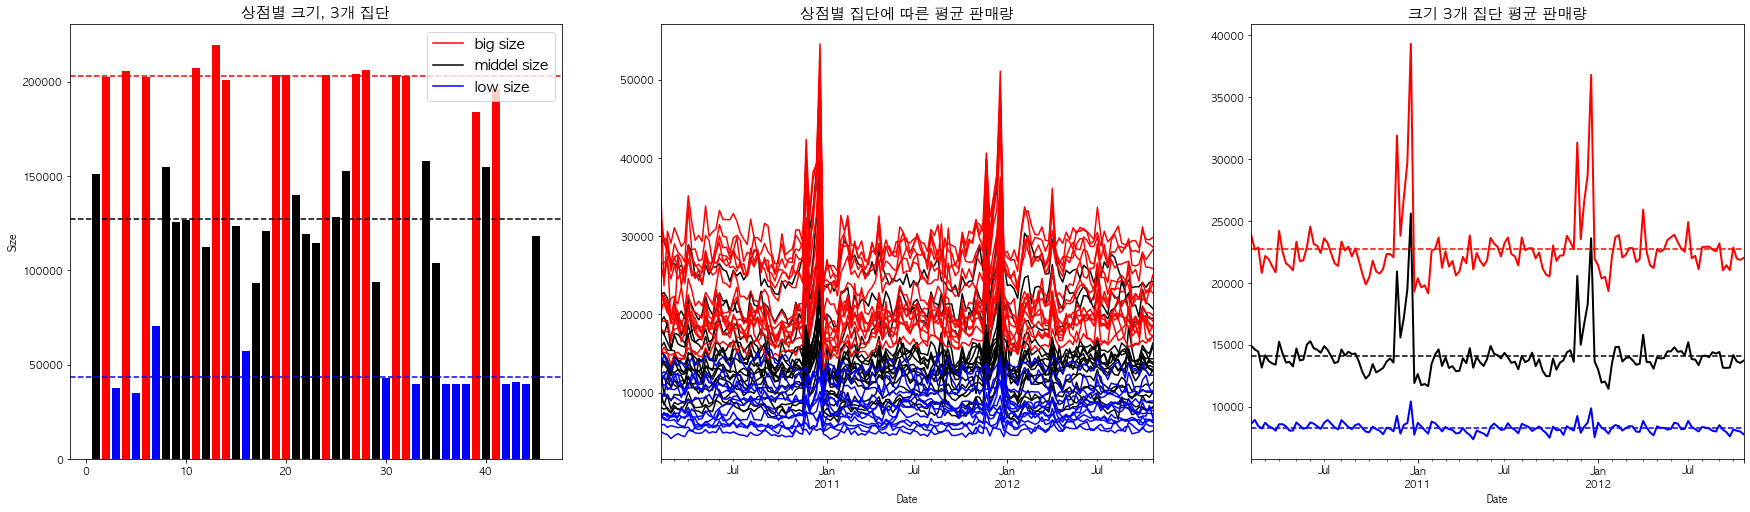

In [78]:
fig, ax = plt.subplots(1,3, figsize=(30,8))
ax = ax.flatten()

# 1
ax[0].bar(result_df3[result_df3['Size']<=75000].index,result_df3[result_df3['Size']<=75000]['Size'],color='b')
ax[0].bar(result_df3[(result_df3['Size'] >= 75000) & (result_df3['Size'] <= 160000)].index,result_df3[(result_df3['Size'] >= 75000) & (result_df3['Size'] <= 160000)]['Size'],color='black')
ax[0].bar(result_df3[result_df3['Size']>160000].index,result_df3[result_df3['Size']>160000]['Size'],color='r')
ax[0].set_ylabel("Size")
ax[0].set_title("상점별 크기, 3개 집단",fontsize=15)
red_line = mlines.Line2D([], [], color='red',linestyle = '-', label='big size')
black_line = mlines.Line2D([], [], color='black',linestyle = '-', label='middel size')
blue_line = mlines.Line2D([], [], color='blue',linestyle = '-', label='low size')
ax[0].legend(handles=[red_line,black_line,blue_line],fontsize=15)
ax[0].axhline(y=result_df3[result_df3['clusterID']==0]['Size'].mean(),color='black',linestyle='--')
ax[0].axhline(y=result_df3[result_df3['clusterID']==2]['Size'].mean(),color='r',linestyle='--')
ax[0].axhline(y=result_df3[result_df3['clusterID']==1]['Size'].mean(),color='b',linestyle='--')

# 2
for i in result_df3[result_df3['clusterID']==0].T.columns:
    train_features[train_features['Store'] == i]['Weekly_Sales'].groupby(train_features['Date']).mean().plot(color='black',label='middle',ax=ax[1])
for i in result_df3[result_df3['clusterID']==1].T.columns:
    train_features[train_features['Store'] == i]['Weekly_Sales'].groupby(train_features['Date']).mean().plot(color='b',label='low',ax=ax[1])
for i in result_df3[result_df3['clusterID']==2].T.columns:
    train_features[train_features['Store'] == i]['Weekly_Sales'].groupby(train_features['Date']).mean().plot(color='r',label='high',ax=ax[1])  
ax[1].set_title("상점별 집단에 따른 평균 판매량",fontsize=15)

# 3
temp0 = pd.DataFrame()
for i in result_df3[result_df3['clusterID']==0].index:
    temp0 = temp0.append(train_features[train_features['Store']==i]['Weekly_Sales'].groupby(train_features['Date']).mean())
temp0.T.mean(axis=1).plot(color='black',linewidth=2,ax=ax[2])

temp1 = pd.DataFrame()
for i in result_df3[result_df3['clusterID']==1].index:
    temp1 = temp1.append(train_features[train_features['Store']==i]['Weekly_Sales'].groupby(train_features['Date']).mean())
temp1.T.mean(axis=1).plot(color='b',linewidth=2,ax=ax[2])

temp2 = pd.DataFrame()
for i in result_df3[result_df3['clusterID']==2].index:
    temp2 = temp2.append(train_features[train_features['Store']==i]['Weekly_Sales'].groupby(train_features['Date']).mean())
temp2.T.mean(axis=1).plot(color='r',linewidth=2,ax=ax[2])
ax[2].axhline(y=temp0.T.mean().mean(),color='black',linestyle='--')
ax[2].axhline(y=temp1.T.mean().mean(),color='b',linestyle='--')
ax[2].axhline(y=temp2.T.mean().mean(),color='r',linestyle='--')
ax[2].set_title("크기 3개 집단 평균 판매량",fontsize=15)
plt.show()

## 2.3 판매량에 따른 상점 특성

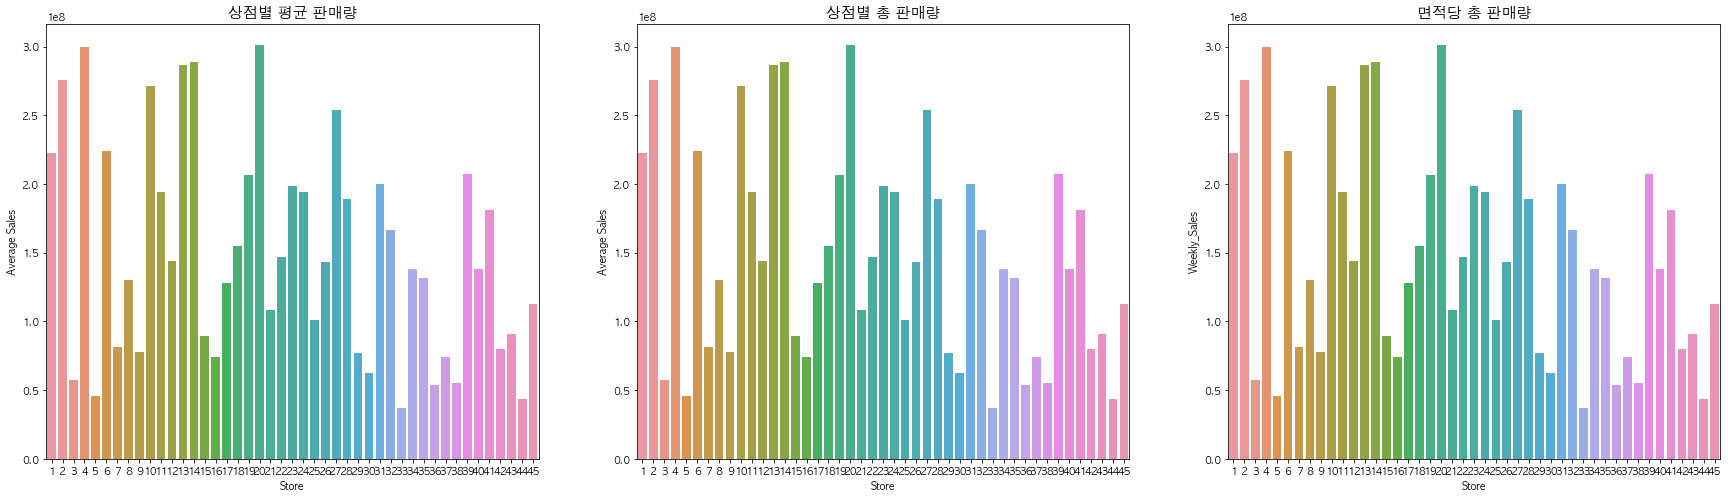

In [82]:
fig, ax = plt.subplots(1,3, figsize=(30,8))
ax = ax.flatten()

sns.barplot(train_features['Weekly_Sales'].groupby(train_features['Store']).sum().index,train_features['Weekly_Sales'].groupby(train_features['Store']).sum().values,ax=ax[0])
ax[0].set_ylabel("Average Sales")
ax[0].set_title("상점별 평균 판매량",fontsize=15)

sns.barplot(train_features['Weekly_Sales'].groupby(train_features['Store']).sum().index,train_features['Weekly_Sales'].groupby(train_features['Store']).sum().values,ax=ax[1])
ax[1].set_ylabel("Average Sales")
ax[1].set_title("상점별 총 판매량",fontsize=15)

sales_per_size = pd.DataFrame(columns=['Store','Store_Mean_Sales'])
for i in sorted(train_features['Store'].unique()):
    sales_per_size = sales_per_size.append(pd.DataFrame([[i,train['Weekly_Sales'].groupby(train['Store']).sum()[i] / train_features[train_features['Store']==i]['Date'].nunique()]],
                                          columns=['Store','Store_Mean_Sales']),ignore_index=True)
sales_per_size.set_index('Store',inplace=True)
sns.barplot(train['Weekly_Sales'].groupby(train['Store']).sum().index,train['Weekly_Sales'].groupby(train['Store']).sum(),ax=ax[2]) 
ax[2].set_title("면적당 총 판매량",fontsize=15)
plt.show()

---
# 3. 부서 분석(타입별 특성)

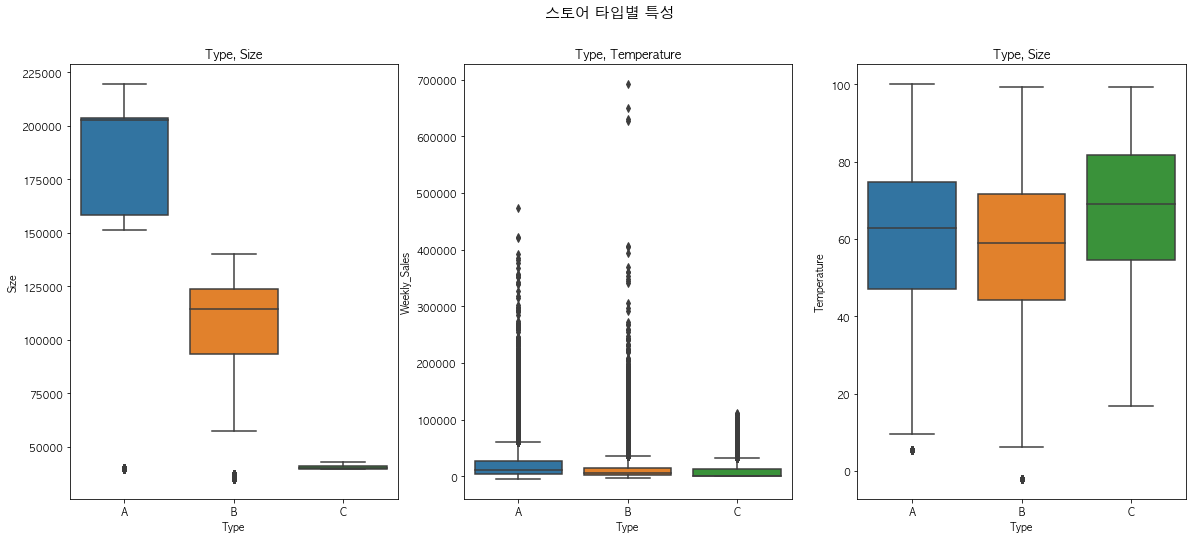

In [84]:
fig, ax = plt.subplots(1,3, figsize=(20,8))
ax = ax.flatten()

sns.boxplot(train_features['Type'],train_features['Size'],ax=ax[0])
ax[0].set_title("Type, Size")
plt.title("Type, Size")

sns.boxplot(train_features['Type'],train_features['Weekly_Sales'],ax=ax[1])
ax[1].set_title("Type, Weekly_Sales")

sns.boxplot(train_features['Type'],train_features['Temperature'],ax=ax[2])
ax[1].set_title("Type, Temperature")
plt.suptitle("스토어 타입별 특성",fontsize=15)
plt.show()

* 크기에 대한 이상치인 3,5,33,36번 부서 Type C로 바꾸기

In [85]:
train_features_type = train_features.copy()

In [86]:
# Dept 3,5,33,36 -> Type C
train_features_type.loc[(train_features_type['Store']==3), 'Type'] = "C"
train_features_type.loc[(train_features_type['Store']==5), 'Type'] = "C"
train_features_type.loc[(train_features_type['Store']==33), 'Type'] = "C"
train_features_type.loc[(train_features_type['Store']==36), 'Type'] = "C"

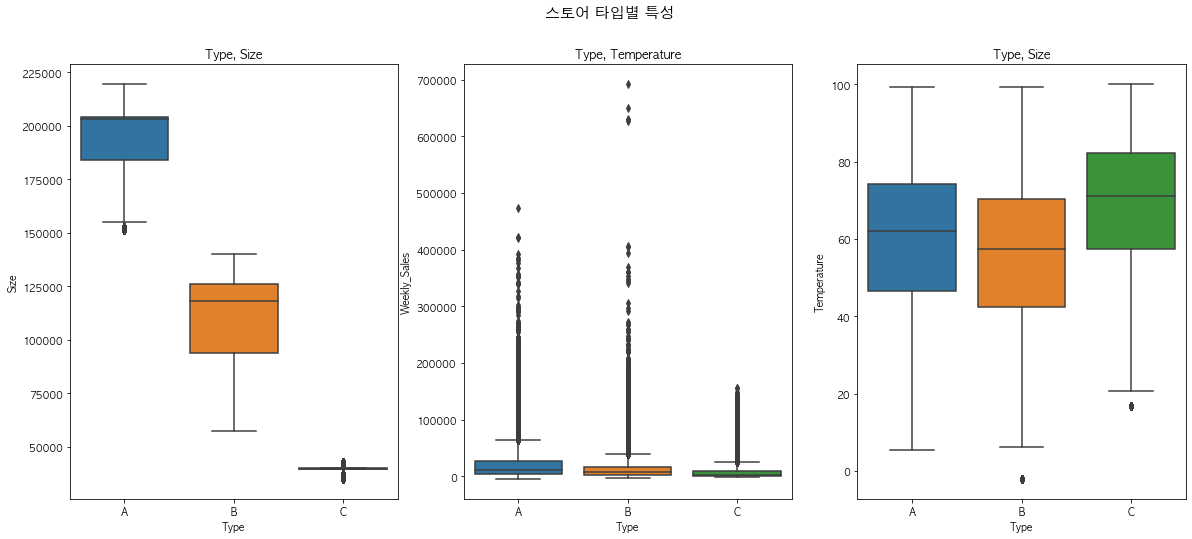

In [102]:
fig, ax = plt.subplots(1,3, figsize=(20,8))
ax = ax.flatten()

sns.boxplot(train_features_type.sort_values(by='Type')['Type'],train_features_type['Size'],ax=ax[0])
ax[0].set_title("Type, Size")
plt.title("Type, Size")

sns.boxplot(train_features_type.sort_values(by='Type')['Type'],train_features_type['Weekly_Sales'],ax=ax[1])
ax[1].set_title("Type, Weekly_Sales")

sns.boxplot(train_features_type.sort_values(by='Type')['Type'],train_features_type['Temperature'],ax=ax[2])
ax[1].set_title("Type, Temperature")
plt.suptitle("스토어 타입별 특성",fontsize=15)
plt.show()

## 3.1 전체 판매량을 활용한 판매량 클러스터링 3개

In [117]:
train_features_2011 = train_features_type[('2011-01-01' <= train_features_type['Date']) & (train_features_type['Date'] < '2012-01-01')]

In [118]:
x = pd.DataFrame(train_features_2011['Weekly_Sales'].groupby(train_features_2011['Dept']).sum())

In [119]:
# 클러스터링 모델 생성
kmeans_2 = KMeans(n_clusters=2, random_state = 42, init='random').fit(x)
result_df2 = x.copy()

# 클러스터 ID 생성
result_df2.loc[:,'clusterID'] = kmeans_2.labels_
# 실루엣 계수값
score_samples = silhouette_samples(result_df2, result_df2['clusterID'])
# 실루엣 계수 컬럼 생성
result_df2.loc[:,'silhouette coefficient'] = score_samples

In [120]:
print('전체 데이터의 실루엣 계수 평균')
print(result_df2['silhouette coefficient'].mean())
print('\n군집별 실루엣 계수 평균')
result_df2.groupby('clusterID')['silhouette coefficient'].mean().reset_index()

전체 데이터의 실루엣 계수 평균
0.7035520601550236

군집별 실루엣 계수 평균


,clusterID,silhouette coefficient
0,0,0.768
1,1,0.394


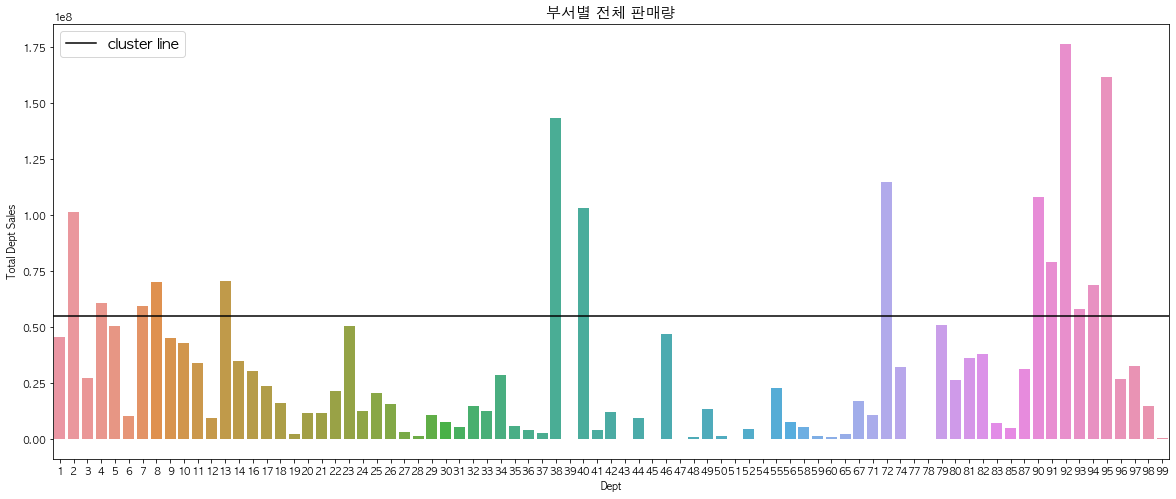

In [122]:
plt.figure(figsize=(20,8))
sns.barplot(result_df2.index,result_df2['Weekly_Sales'])
plt.ylabel("Total Dept Sales")
plt.axhline(y=55000000,color='black')
plt.title("부서별 전체 판매량",fontsize=15)
black_line = mlines.Line2D([], [], color='black',linestyle = '-', label='cluster line')
plt.legend(handles=[black_line],fontsize=15)
plt.show()

In [123]:
LQ = [i for i in result_df2[result_df2['Weekly_Sales'] <= 50681248.45].index] # 0
HQ = [i for i in result_df2[result_df2['Weekly_Sales'] >= 58229085.82].index] # 1

## 3.2 주간변동계수

In [112]:
temp_df = pd.DataFrame()
temp_df2 = pd.DataFrame()
for i in sorted(train_features['Dept'].unique()):
    temp = pd.DataFrame(train_features[train_features['Dept']==i]['Weekly_Sales'].groupby(train_features['Date']).mean())
    temp_df = pd.concat([temp_df,temp],axis=1)
x = pd.concat([temp_df,temp_df2],axis=1)
x.columns = [i for i in sorted(train_features['Dept'].unique())]
x = x.fillna(0)

In [113]:
all_sds_df = pd.DataFrame(columns=['Dept','CV'])
for idx,i in zip(x.columns,range(len(x.T))):
    all_sds_df = all_sds_df.append(pd.DataFrame([[idx,np.std(x.iloc[:,i])/np.mean(x.iloc[:,i])]],
                                          columns=['Dept','CV']),ignore_index=True)
all_sds_df.set_index('Dept',inplace=True)

In [116]:
HV = all_sds_df[abs(all_sds_df.sort_values(by='CV',ascending=False)) > 0.25].dropna().index
MV = all_sds_df[abs((all_sds_df.sort_values(by='CV',ascending=False)) >= 0.1) & (abs(all_sds_df.sort_values(by='CV',ascending=False)) <= 0.25)].dropna().index
LV = all_sds_df[abs(all_sds_df.sort_values(by='CV',ascending=False)) < 0.1].dropna().index
# abs(all_sds_df[all_sds_df.sort_values(by='CV',ascending=False) > 0.25].dropna()).head(3)

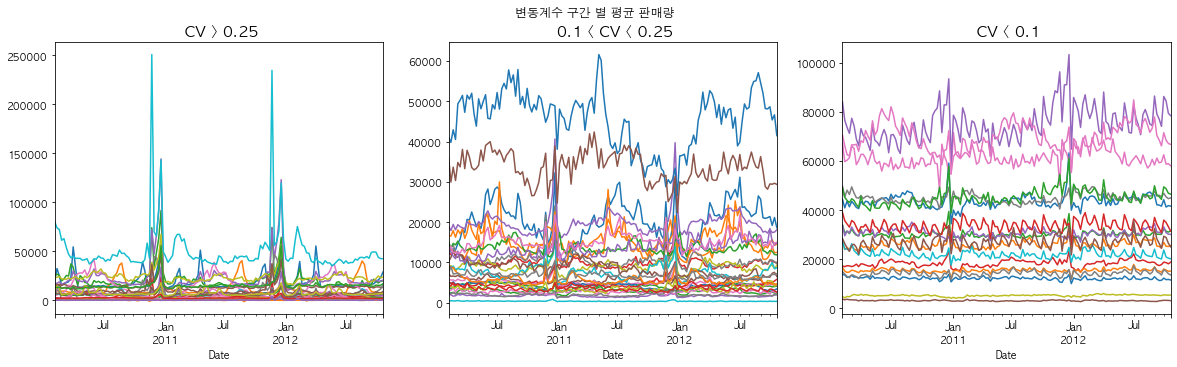

In [115]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()

for i in all_CV_HV:
    x[i].plot(ax=ax[0])
    ax[0].set_title(" CV > 0.25",fontsize=15)

for i in all_CV_MV:
    x[i].plot(ax=ax[1])
    ax[1].set_title(" 0.1 < CV < 0.25",fontsize=15)

for i in all_CV_LV:
    x[i].plot(ax=ax[2])
    ax[2].set_title(" CV < 0.1",fontsize=15)
plt.suptitle("변동계수 구간 별 평균 판매량",fontsize=12)
plt.legend().remove()
plt.show()

* CV < 0.1  :  안정적
* 0.1 < CV < 0.3  : 대체로 안정적
* CV > 0.3  :  불안정

## 3.3 부서별 수요 특징(3x2 매트릭스)

In [125]:
# 변동계수 < 0.25
LQ_LV = sorted(list(set(all_CV_LV) & set(LQ)))
HQ_LV = sorted(list(set(all_CV_LV) & set(HQ)))

# 0.1 < 변동계수 < 0.25
LQ_MV = sorted(list(set(all_CV_MV) & set(LQ)))
HQ_MV = sorted(list(set(all_CV_MV) & set(HQ)))

# 변동계수 > 0.25
LQ_HV = sorted(list(set(all_CV_HV) & set(LQ)))
HQ_HV = sorted(list(set(all_CV_HV) & set(HQ)))

## 3.4 부서별 분기 판매량

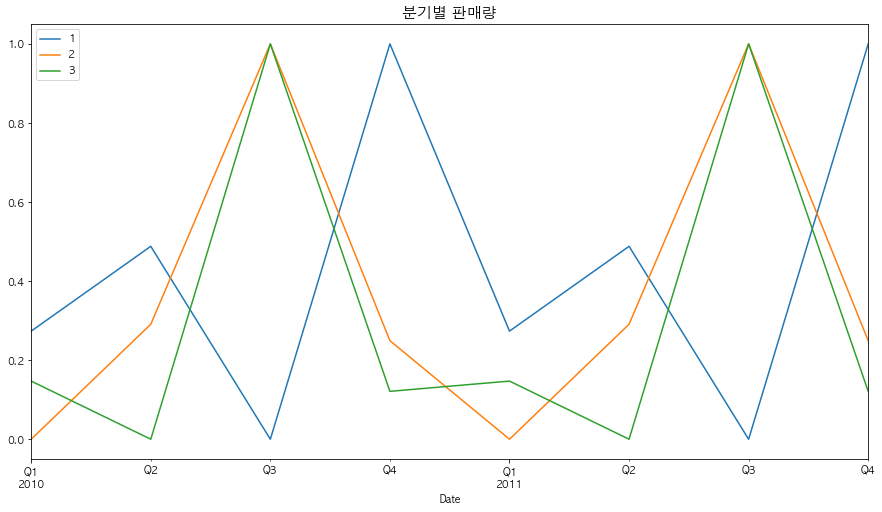

In [267]:
q_df = train_features_type[(train_features_type['Date'] >= '2010-04-01') & (train_features_type['Date'] < '2012-01-01')]
q1_2010 = train_features_type[train_features_type['Date'] < '2010-04-01']

dept = [1,2,3]
for i in dept:
    temp_df = pd.DataFrame()
    temp_df2 = pd.DataFrame()
    x = pd.DataFrame(q_df[q_df['Dept']==i].set_index('Date').resample('QS')['Weekly_Sales'].mean())
    x.loc['2010-01-01'] = q1_2010[q1_2010['Dept']==i]['Weekly_Sales'].mean()
    x = x.reset_index()
    pd.to_datetime(x['Date'])
    x = x.sort_values(by='Date')
    x = x.set_index('Date')
    temp_df = pd.concat([temp_df,x],axis=1)
    try:
        date_sales_q = pd.concat([temp_df,temp_df2])
        result_add_q = seasonal_decompose(date_sales_q,model='additive')
    except:
        pass
    ((result_add_q.seasonal-result_add_q.seasonal.min()) / (result_add_q.seasonal.max() - result_add_q.seasonal.min())).plot(figsize=(15,8)) 
    # result_add_q.seasonal.plot(ax=ax[1])
    plt.title("분기별 판매량",fontsize=15)
    plt.legend(dept)

## 3.5 부서별 연간 판매 추이

In [248]:
one_zero_high = [] # 1, 0, >=0.5       # 감소 - 증가
one_zero_low = [] # 1, 0, < 0.5        # 감소 - 증가
v_dept_high = [] # >=0.5, 0, 1         # 감소 - 증가
v_dept_low = [] # <0.5, 0 , 1          # 감소 - 증가
zero_one_high = [] # 0, 1, >=0.5       # 증가 - 감소
zero_one_low = [] # 0, 1, <0.5         # 증가 - 감소
reverse_v_high = [] # >=0.5, 1, 0      # 증가 - 감소
reverse_v_low = [] # <0.5, 1, 0        # 증가 - 감소
desc_dept_high = [] # 1, >=0.5, 0      # 감소
desc_dept_low = [] # 1, <0.5, 0        # 감소
asc_dept_high = [] # 0, >=0.5, 1       #증가
asc_dept_low = [] # 0, <0.5, 1         #증가

for i in sorted(train_features_type['Dept'].unique()):
    
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    date_sales = pd.DataFrame((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).reset_index()
    # 감소 - 증가
    if (date_sales[date_sales['Weekly_Sales'] == 1].index == 0) & (date_sales[date_sales['Weekly_Sales'] == 0].index == 1) & (date_sales[date_sales['Weekly_Sales'] >= 0.5].index[-1] == 2):
        one_zero_high.append(i)
    elif (date_sales[date_sales['Weekly_Sales'] == 1].index == 0) & (date_sales[date_sales['Weekly_Sales'] == 0].index == 1) & (date_sales[date_sales['Weekly_Sales'] < 0.5].index[-1] == 2):
        one_zero_low.append(i)
    
    # 감소 - 증가
    elif (date_sales[date_sales['Weekly_Sales'] == 0].index == 1) & (date_sales[date_sales['Weekly_Sales'] == 1].index == 2) & (date_sales[date_sales['Weekly_Sales'] >= 0.5].index[0] == 0):
        v_dept_high.append(i)
    elif (date_sales[date_sales['Weekly_Sales'] == 0].index == 1) & (date_sales[date_sales['Weekly_Sales'] == 1].index == 2) & (date_sales[date_sales['Weekly_Sales'] < 0.5].index[0] == 0):
        v_dept_low.append(i)
    
    # 증가 - 감소
    elif (date_sales[date_sales['Weekly_Sales'] == 1].index == 1) & (date_sales[date_sales['Weekly_Sales'] == 0].index == 0) & (date_sales[date_sales['Weekly_Sales'] >= 0.5].index[-1] == 2):
        zero_one_high.append(i)
    elif (date_sales[date_sales['Weekly_Sales'] == 1].index == 1) & (date_sales[date_sales['Weekly_Sales'] == 0].index == 0) & (date_sales[date_sales['Weekly_Sales'] < 0.5].index[-1] == 2):
        zero_one_low.append(i)
    
    # 증가 - 감소
    elif (date_sales[date_sales['Weekly_Sales'] == 0].index == 2) & (date_sales[date_sales['Weekly_Sales'] == 1].index == 1) & (date_sales[date_sales['Weekly_Sales'] >= 0.5].index[0] == 0):
        reverse_v_high.append(i)
    elif (date_sales[date_sales['Weekly_Sales'] == 0].index == 2) & (date_sales[date_sales['Weekly_Sales'] == 1].index == 1) & (date_sales[date_sales['Weekly_Sales'] < 0.5].index[0] == 0):
        reverse_v_low.append(i)
    
    # 감소
    elif (date_sales[date_sales['Weekly_Sales'] == 1].index == 0) & (date_sales[date_sales['Weekly_Sales'] == 0].index == 2) & (date_sales[date_sales['Weekly_Sales'] >= 0.5].index[-1] == 1):
        desc_dept_high.append(i)
    elif (date_sales[date_sales['Weekly_Sales'] == 1].index == 0) & (date_sales[date_sales['Weekly_Sales'] == 0].index == 2) & (date_sales[date_sales['Weekly_Sales'] < 0.5].index[0] == 1):
        desc_dept_low.append(i)
    
    # 증가
    elif (date_sales[date_sales['Weekly_Sales'] == 0].index == 0) & (date_sales[date_sales['Weekly_Sales'] == 1].index == 2) & (date_sales[date_sales['Weekly_Sales'] >= 0.5].index[0] == 1):
        asc_dept_high.append(i)
    elif (date_sales[date_sales['Weekly_Sales'] == 0].index == 0) & (date_sales[date_sales['Weekly_Sales'] == 1].index == 2) & (date_sales[date_sales['Weekly_Sales'] < 0.5].index[-1] == 1):
        asc_dept_low.append(i)


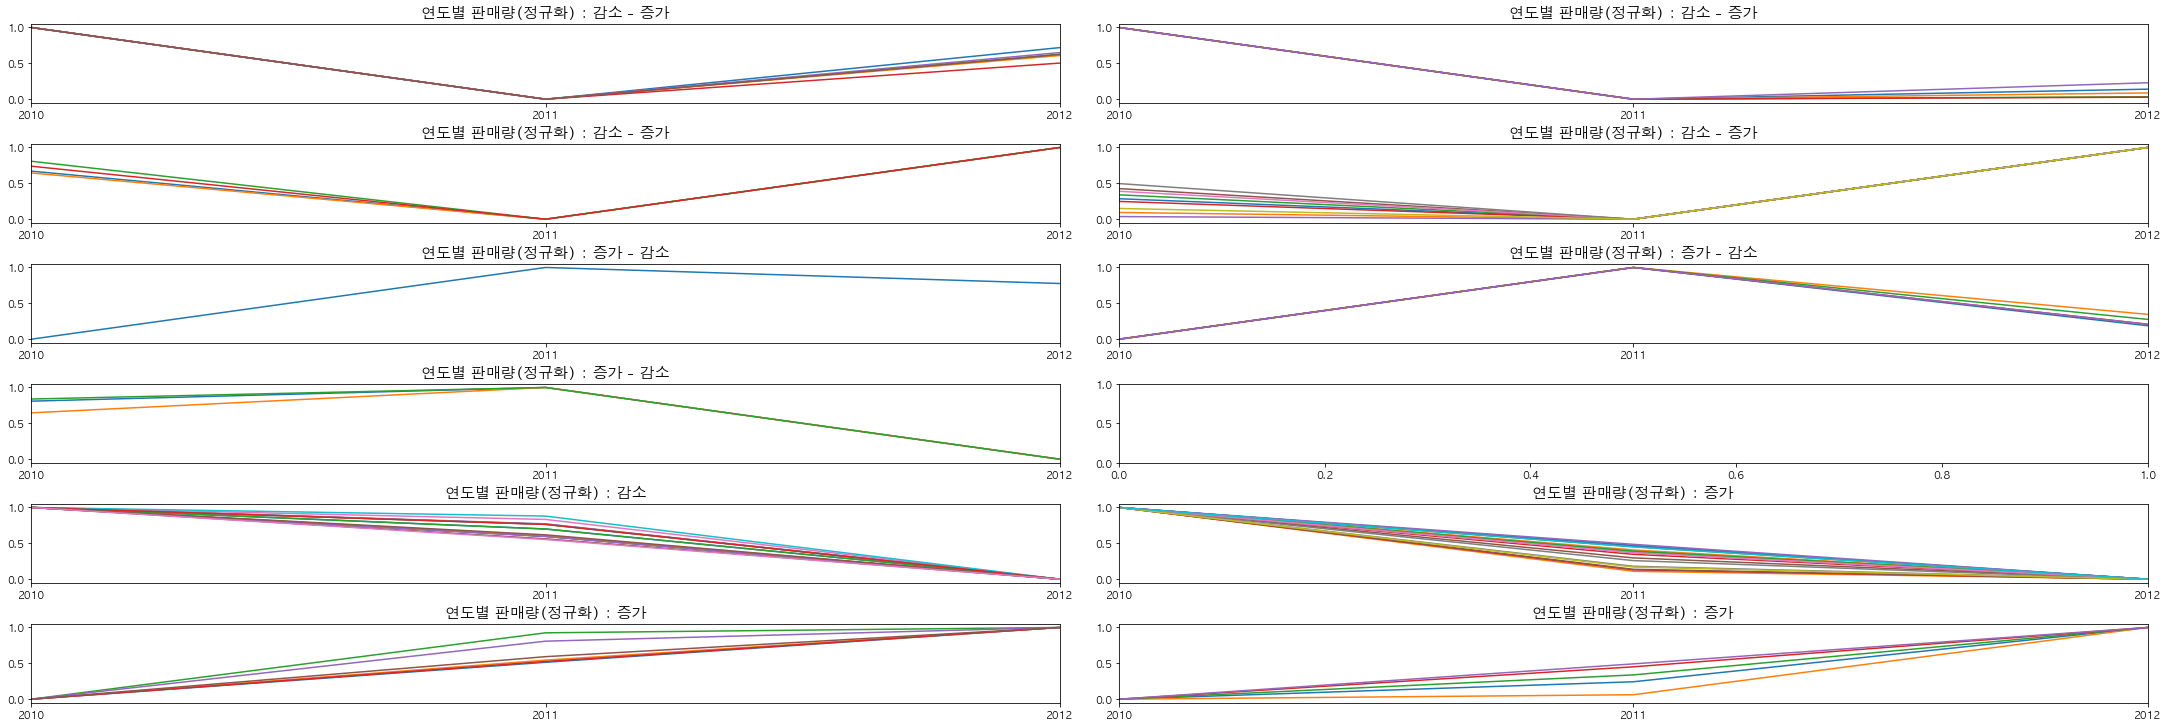

In [249]:
fig, ax = plt.subplots(6,2, figsize=(30,10),constrained_layout=True)
ax = ax.flatten()
# plt.tight_layout()

for i in one_zero_high:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[0])   
    ax[0].set_xlabel(None)
    ax[0].set_title("연도별 판매량(정규화) : 감소 - 증가",fontsize=15)
for i in one_zero_low:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[1])
    ax[1].set_xlabel(None)
    ax[1].set_title("연도별 판매량(정규화) : 감소 - 증가",fontsize=15)
for i in v_dept_high:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[2])
    ax[2].set_xlabel(None)
    ax[2].set_title("연도별 판매량(정규화) : 감소 - 증가",fontsize=15)
for i in v_dept_low:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[3])
    ax[3].set_xlabel(None)
    ax[3].set_title("연도별 판매량(정규화) : 감소 - 증가",fontsize=15)
for i in zero_one_high:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[4])   
    ax[4].set_xlabel(None)
    ax[4].set_title("연도별 판매량(정규화) : 증가 - 감소",fontsize=15)
for i in zero_one_low:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[5])
    ax[5].set_xlabel(None)
    ax[5].set_title("연도별 판매량(정규화) : 증가 - 감소",fontsize=15)
for i in reverse_v_high:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[6])  
    ax[6].set_xlabel(None)
    ax[6].set_title("연도별 판매량(정규화) : 증가 - 감소",fontsize=15)
for i in reverse_v_low:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[7])  
    ax[7].set_xlabel(None)
    ax[7].set_title("연도별 판매량(정규화) : 증가 - 감소",fontsize=15)
for i in desc_dept_high:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[8]) 
    ax[8].set_xlabel(None)
    ax[8].set_title("연도별 판매량(정규화) : 감소",fontsize=15)
for i in desc_dept_low:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[9])  
    ax[9].set_xlabel(None)
    ax[9].set_title("연도별 판매량(정규화) : 증가",fontsize=15)
for i in asc_dept_high:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[10])  
    ax[10].set_xlabel(None)
    ax[10].set_title("연도별 판매량(정규화) : 증가",fontsize=15)
for i in asc_dept_low:
    date_sales = train_features_type[train_features_type['Dept']==i].set_index('Date').resample('y')['Weekly_Sales'].mean()
    ((date_sales-date_sales.min()) / (date_sales.max() - date_sales.min())).plot(ax=ax[11])  
    ax[11].set_xlabel(None)
    ax[11].set_title("연도별 판매량(정규화) : 증가",fontsize=15)


---

# 4. 전체 상점과 개별 상점의 정합성
* 정확한 분석을 위해 2011년 데이터 사용

## 4.1 전체 상점과 개별 상점의 총 판매량 비교

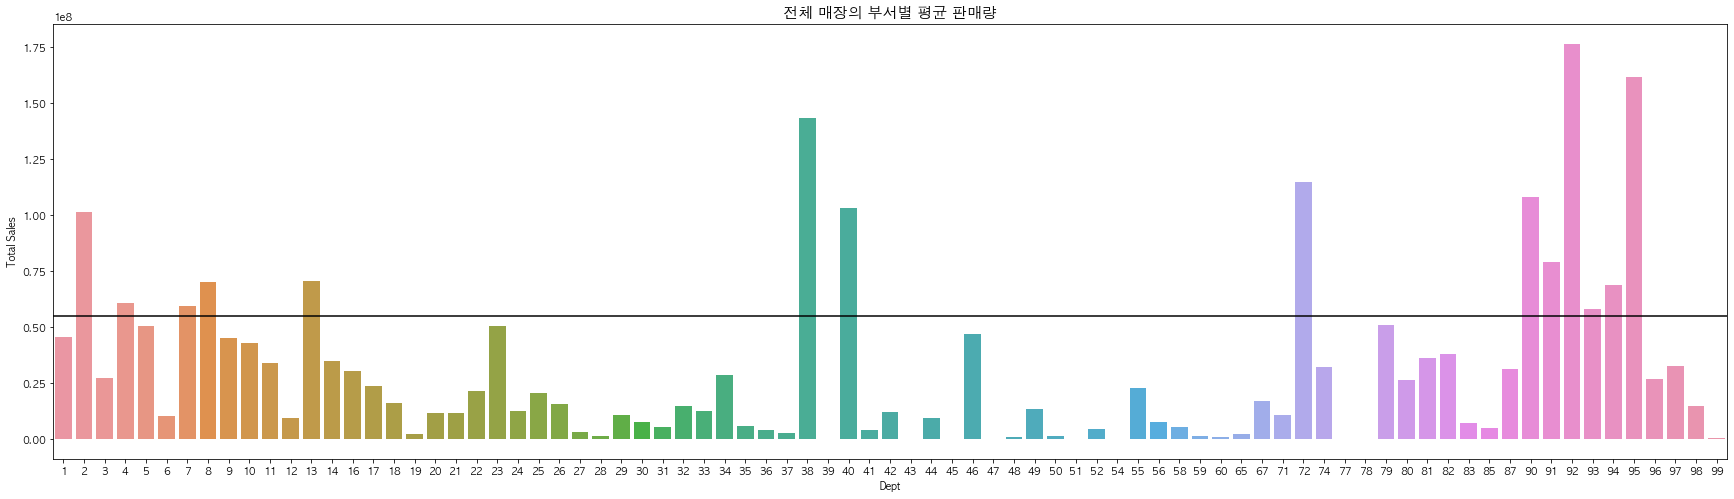

In [195]:
plt.figure(figsize=(30,8))
sns.barplot(train_features_2011['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().index,train_features_2011['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().values)
plt.ylabel("Total Sales")
plt.axhline(y=55000000,color='black')
plt.title("전체 매장의 부서별 평균 판매량",fontsize=15)
plt.show()

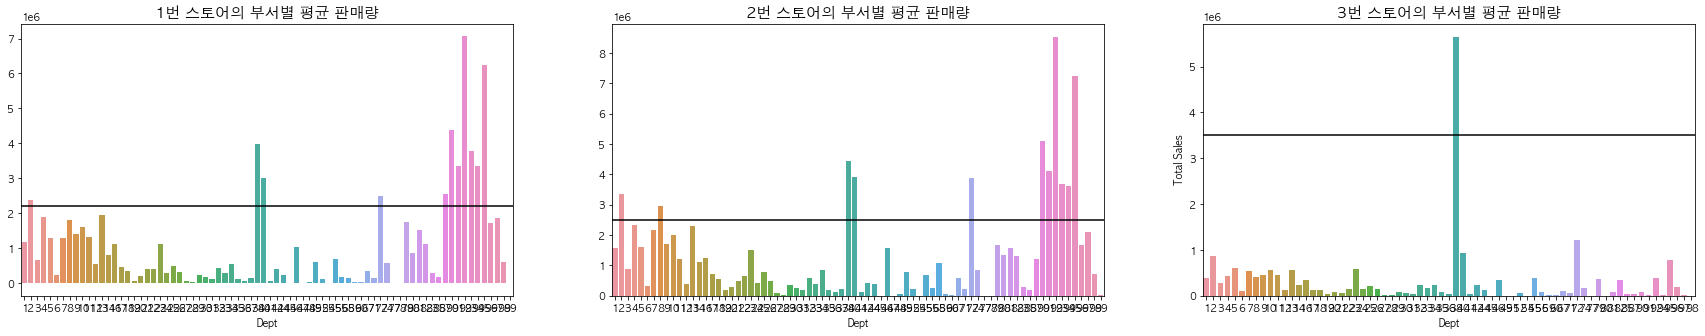

In [154]:
fig, ax = plt.subplots(1,3, figsize=(30,5))
ax = ax.flatten()

store = 1
sns.barplot(train_features_2011[train_features_2011['Store']==store]['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().index,train_features_2011[train_features_2011['Store']==store]['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().values,ax=ax[0])
plt.ylabel("Total Sales")
ax[0].axhline(y=2200000,color='black')
ax[0].set_title("1번 스토어의 부서별 평균 판매량",fontsize=15)

store = 2
sns.barplot(train_features_2011[train_features_2011['Store']==store]['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().index,train_features_2011[train_features_2011['Store']==store]['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().values,ax=ax[1])
plt.ylabel("Total Sales")
ax[1].axhline(y=2500000,color='black')
ax[1].set_title("2번 스토어의 부서별 평균 판매량",fontsize=15)

store = 3
sns.barplot(train_features_2011[train_features_2011['Store']==store]['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().index,train_features_2011[train_features_2011['Store']==store]['Weekly_Sales'].groupby(train_features_2011['Dept']).sum().values,ax=ax[2])
plt.ylabel("Total Sales")
ax[2].axhline(y=3500000,color='black')
ax[2].set_title("3번 스토어의 부서별 평균 판매량",fontsize=15)
plt.show()

## 4.2 전체 상점과 개별 상점의 주간변동계수 비교

In [206]:
temp_df = pd.DataFrame()
temp_df2 = pd.DataFrame()
for i in sorted(train_features['Dept'].unique()):
    temp = pd.DataFrame(train_features[train_features['Dept']==i]['Weekly_Sales'].groupby(train_features['Date']).mean())
    temp_df = pd.concat([temp_df,temp],axis=1)
x = pd.concat([temp_df,temp_df2],axis=1)
x.columns = [i for i in sorted(train_features['Dept'].unique())]
x = x.fillna(0)

all_sds_df = pd.DataFrame(columns=['Dept','CV'])
for idx,i in zip(x.columns,range(len(x.T))):
    all_sds_df = all_sds_df.append(pd.DataFrame([[idx,np.std(x.iloc[:,i])/np.mean(x.iloc[:,i])]],
                                          columns=['Dept','CV']),ignore_index=True)
all_sds_df.set_index('Dept',inplace=True)

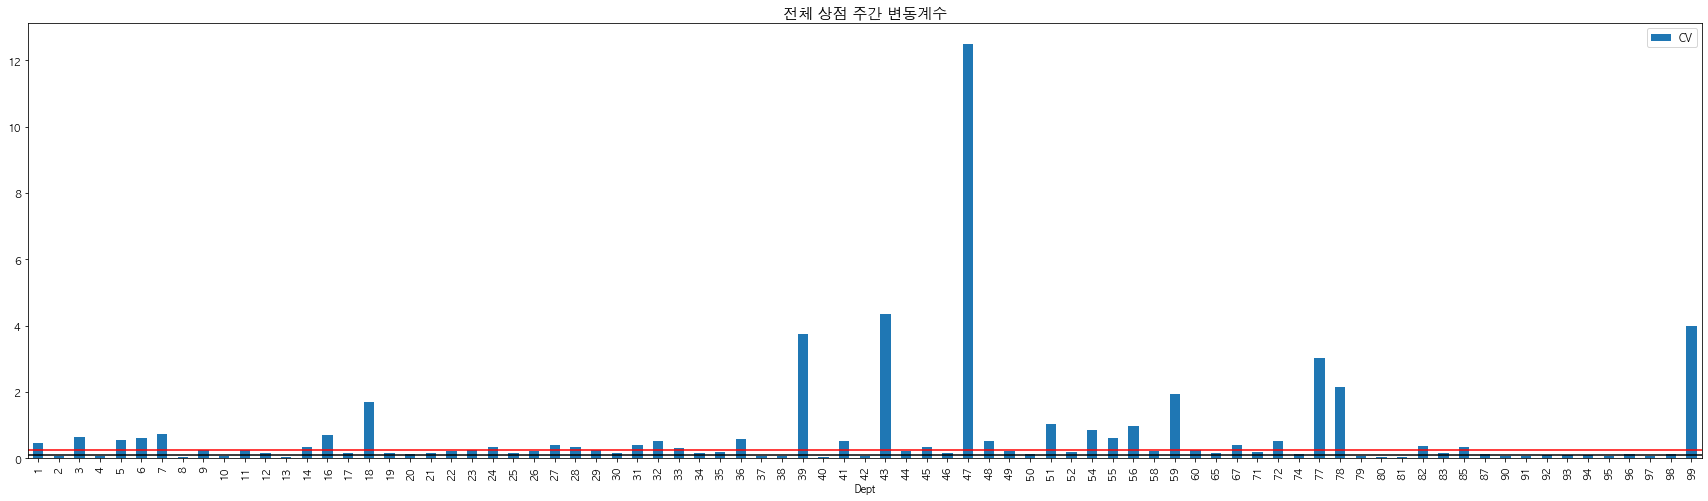

In [207]:
abs(all_sds_df).plot(kind='bar',figsize=(30,8))
plt.axhline(0.1,color='black')
plt.axhline(0.25,color='r')
plt.title("전체 상점 주간 변동계수",fontsize=15)
plt.show()

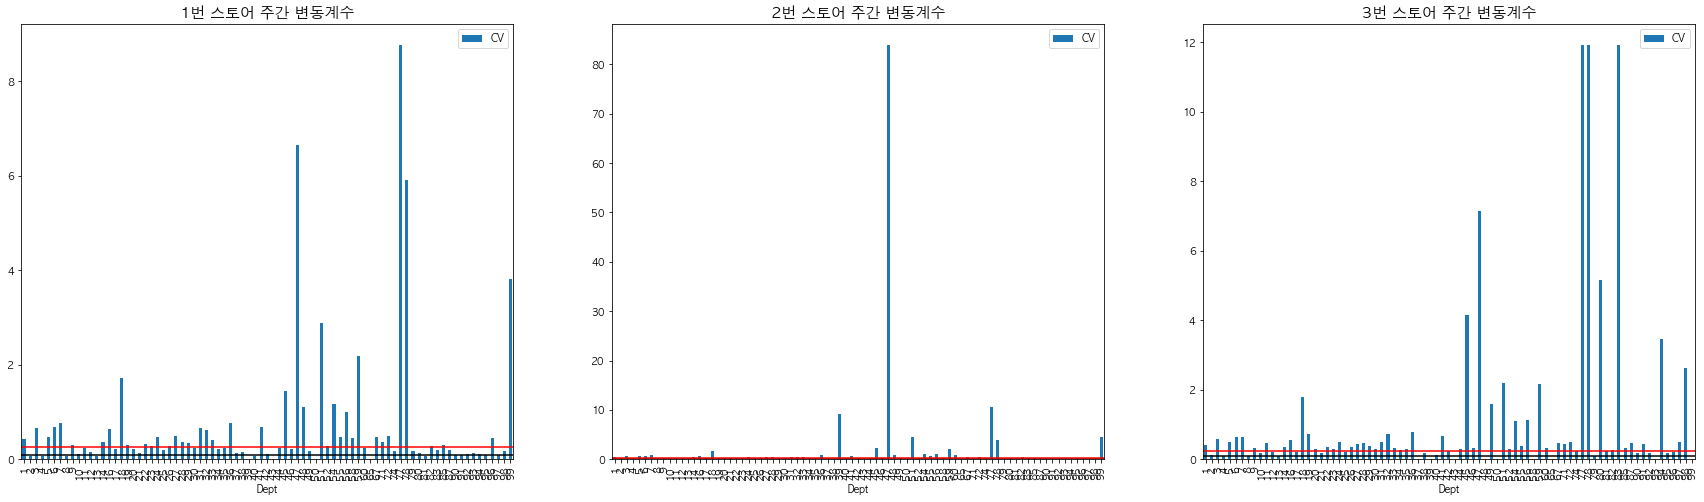

In [216]:
fig, ax = plt.subplots(1,3, figsize=(30,8))
ax = ax.flatten()

store = 1
temp_df = pd.DataFrame()
temp_df2 = pd.DataFrame()
for i in sorted(train_features['Dept'].unique()):
    temp = pd.DataFrame(train_features[(train_features['Store']==store) & (train_features['Dept']==i)]['Weekly_Sales'].groupby(train_features['Date']).mean())
    temp_df = pd.concat([temp_df,temp],axis=1)
x = pd.concat([temp_df,temp_df2],axis=1)
x.columns = [i for i in sorted(train_features['Dept'].unique())]
x = x.fillna(0)
all_sds_df = pd.DataFrame(columns=['Dept','CV'])
for idx,i in zip(x.columns,range(len(x.T))):
    all_sds_df = all_sds_df.append(pd.DataFrame([[idx,np.std(x.iloc[:,i])/np.mean(x.iloc[:,i])]],
                                          columns=['Dept','CV']),ignore_index=True)
all_sds_df.set_index('Dept',inplace=True)

abs(all_sds_df).plot(kind='bar',ax=ax[0])
ax[0].axhline(0.1,color='black')
ax[0].axhline(0.25,color='r')
ax[0].set_title("1번 스토어 주간 변동계수",fontsize=15)

store = 2
temp_df = pd.DataFrame()
temp_df2 = pd.DataFrame()
for i in sorted(train_features['Dept'].unique()):
    temp = pd.DataFrame(train_features[(train_features['Store']==store) & (train_features['Dept']==i)]['Weekly_Sales'].groupby(train_features['Date']).mean())
    temp_df = pd.concat([temp_df,temp],axis=1)
x = pd.concat([temp_df,temp_df2],axis=1)
x.columns = [i for i in sorted(train_features['Dept'].unique())]
x = x.fillna(0)
all_sds_df = pd.DataFrame(columns=['Dept','CV'])
for idx,i in zip(x.columns,range(len(x.T))):
    all_sds_df = all_sds_df.append(pd.DataFrame([[idx,np.std(x.iloc[:,i])/np.mean(x.iloc[:,i])]],
                                          columns=['Dept','CV']),ignore_index=True)
all_sds_df.set_index('Dept',inplace=True)

abs(all_sds_df).plot(kind='bar',ax=ax[1])
ax[1].axhline(0.1,color='black')
ax[1].axhline(0.25,color='r')
ax[1].set_title("2번 스토어 주간 변동계수",fontsize=15)

store = 3
temp_df = pd.DataFrame()
temp_df2 = pd.DataFrame()
for i in sorted(train_features['Dept'].unique()):
    temp = pd.DataFrame(train_features[(train_features['Store']==store) & (train_features['Dept']==i)]['Weekly_Sales'].groupby(train_features['Date']).mean())
    temp_df = pd.concat([temp_df,temp],axis=1)
x = pd.concat([temp_df,temp_df2],axis=1)
x.columns = [i for i in sorted(train_features['Dept'].unique())]
x = x.fillna(0)
all_sds_df = pd.DataFrame(columns=['Dept','CV'])
for idx,i in zip(x.columns,range(len(x.T))):
    all_sds_df = all_sds_df.append(pd.DataFrame([[idx,np.std(x.iloc[:,i])/np.mean(x.iloc[:,i])]],
                                          columns=['Dept','CV']),ignore_index=True)
all_sds_df.set_index('Dept',inplace=True)

abs(all_sds_df).plot(kind='bar',ax=ax[2])
ax[2].axhline(0.1,color='black')
ax[2].axhline(0.25,color='r')
ax[2].set_title("3번 스토어 주간 변동계수",fontsize=15)
plt.show()

## 4.3 전체 판매량, 주간변동계수 정확도

#### DataFrame 생성을 위한 함수 정의

In [231]:
def make_quarter(store,dept):

    # 4분기를 구하려면 8개의 주기가 필요하기때문에 2010년,2011년 자료 사용
    '''
    date range : 2010 ~ 2011 (구하려고 하는 년도 + 이전 년도의 수치 필요)
    '''
    dataframe = train_features[(train_features['Store']==store) & (train_features['Dept']==dept)]
    q_df = dataframe[(dataframe['Date'] >= '2010-04-01') & (dataframe['Date'] < '2012-01-01')]
    q1_2010 = dataframe[dataframe['Date'] < '2010-04-01']

    x = pd.DataFrame(q_df.set_index('Date').resample('QS')['Weekly_Sales'].mean())
    x.loc['2010-01-01'] = q1_2010['Weekly_Sales'].mean()
    x = x.fillna(0)
    x = x.reset_index()
    pd.to_datetime(x['Date'])
    x = x.sort_values(by='Date')
    x = x.set_index('Date')
    
    result_add_q = seasonal_decompose(x,model='additive')
    if store in store_sales_high:    
        if dept in HQ:
            if result_add_q.seasonal[0] == result_add_q.seasonal.max():
                return "q1"

            elif result_add_q.seasonal[1] == result_add_q.seasonal.max():
                return "q2"

            elif result_add_q.seasonal[2] == result_add_q.seasonal.max():
                return "q3"

            elif result_add_q.seasonal[3] == result_add_q.seasonal.max():
                return "q4"
        else:
            return "wrong"
        
        
        
                        ####################################
                        ### 분기 최저 판매량은 q 없이 분기 번호만 ###
                        ####################################
      
    elif store in store_sales_low:
        if dept in LQ:
            if result_add_q.seasonal[0] == result_add_q.seasonal.min():
                return "1"

            elif result_add_q.seasonal[1] == result_add_q.seasonal.min():
                return "2"

            elif result_add_q.seasonal[2] == result_add_q.seasonal.min():
                return "3"

            elif result_add_q.seasonal[3] == result_add_q.seasonal.min():
                return "4"
        # elif dept in HQ:
        #     return "empty"


    
                                ##############
                                #  전체 스토어  #
                                ##############    
def make_quarter_all_store(dept):

    # 4분기를 구하려면 8개의 주기가 필요하기때문에 2010년,2011년 자료 사용
    '''
    date range : 2010 ~ 2011 (구하려고 하는 년도 + 이전 년도의 수치 필요)
    '''
    dataframe = train_features[train_features['Dept']==dept]
    q_df = dataframe[(dataframe['Date'] >= '2010-04-01') & (dataframe['Date'] < '2012-01-01')]
    q1_2010 = dataframe[dataframe['Date'] < '2010-04-01']

    x = pd.DataFrame(q_df.set_index('Date').resample('QS')['Weekly_Sales'].mean())
    x.loc['2010-01-01'] = q1_2010['Weekly_Sales'].mean()
    x = x.fillna(0)
    x = x.reset_index()
    pd.to_datetime(x['Date'])
    x = x.sort_values(by='Date')
    x = x.set_index('Date')
    
    result_add_q = seasonal_decompose(x,model='additive')

    if dept in HQ: 
        if result_add_q.seasonal[0] == result_add_q.seasonal.max():
            return "q1"

        elif result_add_q.seasonal[1] == result_add_q.seasonal.max():
            return "q2"

        elif result_add_q.seasonal[2] == result_add_q.seasonal.max():
            return "q3"

        elif result_add_q.seasonal[3] == result_add_q.seasonal.max():
            return "q4"
 
    
    
                        ####################################
                        ### 분기 최저 판매량은 q 없이 분기 번호만 ###
                        ####################################
    if dept in LQ:
        if result_add_q.seasonal[0] == result_add_q.seasonal.min():
            return "1"

        elif result_add_q.seasonal[1] == result_add_q.seasonal.min():
            return "2"

        elif result_add_q.seasonal[2] == result_add_q.seasonal.min():
            return "3"

        elif result_add_q.seasonal[3] == result_add_q.seasonal.min():
            return "4"

#### 보다 높은 정확도를 위해 평균 판매량으로 스토어를 2분류

In [244]:
store_sales_mean = train_features_2011.groupby('Store')['Weekly_Sales'].sum().mean()
store_sales_sum_df = train_features_2011.groupby('Store')['Weekly_Sales'].sum()

store_sales_high = [i for i in store_sales_sum_df[store_sales_sum_df >= store_sales_mean].index]
store_sales_low = [i for i in store_sales_sum_df[store_sales_sum_df < store_sales_mean].index]

######################
## 높은 평균 판매 스토어 ##
######################
high_store_df = pd.DataFrame(index=['whole_Store'])
for s in store_sales_high: 
    temp_store = pd.DataFrame(index=[f'Store{s}'])
    high_store_df = pd.concat([temp_store,high_store_df],axis=0)
high_store_df = high_store_df.loc[::-1,:]
high_store_df = pd.DataFrame()
for s in tqdm(store_sales_high):
    for d in HQ:
        try:
            high_store_df.loc['whole_Store',f'Dept{d}'] = make_quarter_all_store(d)
            high_store_df.loc[f'Store{s}',f'Dept{d}'] = make_quarter(s,d)
        except:
            # high_store_df.loc[f'Store{s}',f'Dept{d}'] = 'empty'
            high_store_df.loc[f'Store{s}',f'Dept{d}'] = np.NaN
high_acc = []
for d in HQ:
    cross_tab = pd.crosstab(high_store_df[f'Dept{d}'][0],high_store_df[f'Dept{d}'][1:])
    x = cross_tab.div(cross_tab.sum(axis=1),axis='index')
    try:
        high_acc.append(round(x[x.index].values[0,0],2))
    except:
        high_acc.append(0)
high_store_df.loc['Acc'] = high_acc
high_store_df = high_store_df.reindex(index=['Acc','whole_Store', 'Store1', 'Store2', 'Store4', 'Store6', 'Store10',
       'Store11', 'Store13', 'Store14', 'Store19', 'Store20', 'Store23',
       'Store24', 'Store27', 'Store28', 'Store31', 'Store32', 'Store39',
       'Store41'])

######################
## 낮은 평균 판매 스토어 ##
######################
low_store_df = pd.DataFrame(index=['whole_Store'])
for s in store_sales_low: 
    temp_store = pd.DataFrame(index=[f'Store{s}'])
    low_store_df = pd.concat([temp_store,low_store_df],axis=0)
low_store_df = low_store_df.loc[::-1,:]
low_store_df = pd.DataFrame()
for s in tqdm(store_sales_low):
    for d in LQ:
        try:
            low_store_df.loc['whole_Store',f'Dept{d}'] = make_quarter_all_store(d)
            low_store_df.loc[f'Store{s}',f'Dept{d}'] = make_quarter(s,d)
        except:
            # low_store_df.loc[f'Store{s}',f'Dept{d}'] = 'empty'
            low_store_df.loc[f'Store{s}',f'Dept{d}'] = np.NaN

low_acc = []
for d in LQ:
    cross_tab = pd.crosstab(low_store_df[f'Dept{d}'][0],low_store_df[f'Dept{d}'][1:])
    x = cross_tab.div(cross_tab.sum(axis=1),axis='index')
    try:
        low_acc.append(round(x[x.index].values[0,0],2))
    except:
        low_acc.append(0)
low_store_df.loc['Acc'] = low_acc
low_store_df = low_store_df.reindex(index=['Acc','whole_Store', 'Store3', 'Store5', 'Store7', 'Store8', 'Store9',
       'Store12', 'Store15', 'Store16', 'Store17', 'Store18', 'Store21',
       'Store22', 'Store25', 'Store26', 'Store29', 'Store30', 'Store33',
       'Store34', 'Store35', 'Store36', 'Store37', 'Store38', 'Store40',
       'Store42', 'Store43', 'Store44', 'Store45'])

100%|███████████████████████████████████████████| 27/27 [00:27<00:00,  1.03s/it]


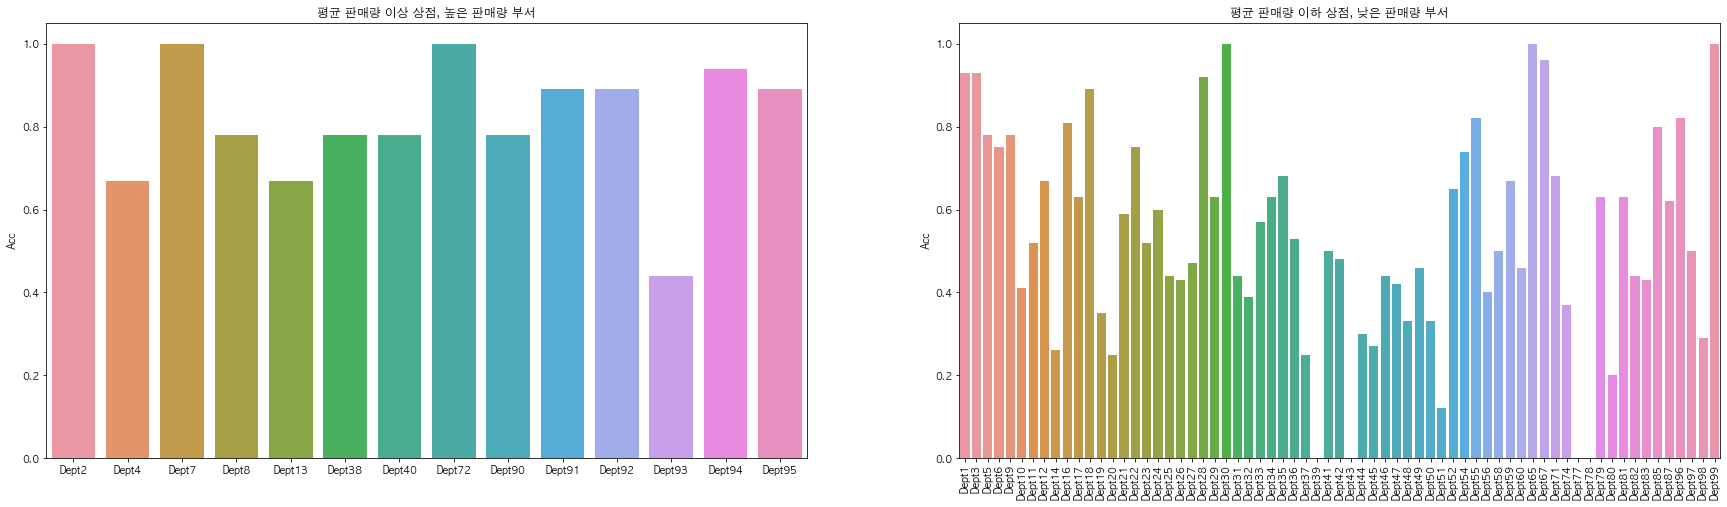

In [247]:
fig, ax = plt.subplots(1,2, figsize=(30,8))
ax = ax.flatten()

sns.barplot(high_store_df.loc['Acc'].index,high_store_df.loc['Acc'],ax=ax[0])
ax[0].set_title("평균 판매량 이상 상점, 높은 판매량 부서")
plt.xticks(rotation=90)

sns.barplot(low_store_df.loc['Acc'].index,low_store_df.loc['Acc'],ax=ax[1])
ax[1].set_title("평균 판매량 이하 상점, 낮은 판매량 부서")
plt.xticks(rotation=90)
plt.show()

* 평균보다 높은 판매량을 가진 상점에서 높은 판매량을 보이는 부서(아이템)에 대한 분류의 정확성은 높다.
* 평균보다 낮은 판매량을 가진 상점에서 낮은 판매량을 보이는 부서(아이템)에 대한 분류의 정확성은 낮다.

---
# 5. 결론

* 상점의 크기를 이용하여 타입 재분류
* 판매량 데이터를 이용하여 상점, 부서 전체판매량(Q), 주간변동계수(CV) 도출
* 전체판매량(Q), 변동계수(CV)를 이용하여 3x2 분류 매트릭스 생성
* 전체 상점과 개별 상점의 특징을 공유할 수 있는지 정합성 확인
* 전체판매량(Q)을 이용한 분류 알고리즘은 80% 이상의 정확도를 보임.
* 변동계수(CV)를 이용한 분류 알고리즘은 70% 이하의 정확도를 보임.
* 전체판매량(Q), 변동계수(CV)를 혼합한 분류 알고리즘은 매우 낮은(약 50%) 정확도를 보임.

### 정확도를 향상 시키기 위해 실 데이터를 이용하여 더 많은 세분화가 필요.